In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt  

In [6]:
env=gym.make("FrozenLake-v1", desc=None, map_name="4x4",is_slippery=True)

In [7]:
class Policy:
    def __init__(self,initial_policy=None,gamma=0.9):
        self.gamma=gamma
        if initial_policy ==None:
           self.policy=np.full((16,4),0.25)
     
        else:
            self.policy=initial_policy
       
        self.N_detailed=np.zeros((16,4,16))
        self.Q=np.zeros((16,4))
        self.v=np.zeros((16))
        self.Returns=[[] for i in range(16)]
        self.Rewards_cum=np.zeros((16,4))
        self.pos_dict={i*4+j: [i,j] for i in range(4) for j in range(4)}

    def act(self, state):
        return np.random.choice(4, p=self.policy[state])
    
    def eval_episode(self,episode):
        states, actions, rewards= episode 
        next_state=states[-1]
        G=0
        for i, state in reversed(list(enumerate(states[:-1]))):
            action=actions[i]
            reward=rewards[i]
            self.Rewards_cum[state,action]+=reward
            G=self.gamma*G + reward
            self.N_detailed[state,action,next_state]+=1
            if state not in states[:i]:
                self.Returns[state].append(G)
                self.v[state]=sum(self.Returns[state])/len(self.Returns[state])
            next_state=state
    
    def compute_q(self):
        for state in range(self.Q.shape[0]):
            for action in range(self.Q.shape[1]):

                s_a_visits=np.sum(self.N_detailed[state,action])
                if s_a_visits==0:
                    s_a_visits=1 # dirty solution to avoiding nan values
                probs_s_a=self.N_detailed[state,action]/s_a_visits
                s_a_rewards=self.Rewards_cum[state,action]/s_a_visits
                self.Q[state,action]=np.dot(probs_s_a,self.v)+s_a_rewards

    def improve_policy(self):
        self.compute_q()
        for state in range(self.Q.shape[0]):
            best_action_value=np.max(self.Q[state])
            base=0
            new_probs=np.zeros(4)
            for i, action_value in enumerate(self.Q[state]):
                if action_value== best_action_value:
                    new_probs[i]=1
                    base+=1
            new_probs=new_probs/base
            self.policy[state] = new_probs
        self.Returns=[[] for i in range(16)]
    def v_mat(self):
        V_mat=np.zeros((4,4))
        for i, val in enumerate(self.v):
            in_1, in_2=self.pos_dict[i]
            V_mat[in_1,in_2]=val
        return V_mat
    
    def policy_mat(self):
        pi_mat=np.zeros((4,4,4))
        for i  in range(self.policy.shape[0]):
            in_1, in_2=self.pos_dict[i]
            pi_mat[in_1,in_2]=self.policy[i]
        return pi_mat
       
    def show_heatmap(self,it_nr):
        fig, ax = plt.subplots()
        V_mat=self.v_mat()
        im = ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(4))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, round(V_mat[i, j], 2),
                            ha="center", va="center", color="w")

        ax.set_title(f"State value function heatmap it={it_nr}")
        fig.tight_layout()
        plt.show()
    
    def show_policy(self,it_nr):
        Pi_mat=self.policy_mat()
        V_mat=self.v_mat()
        policy_arrows_direction = {0: (0,-1), 1: (-1,0), 2:(0,1) , 3:(1,0) }
       

        

        fig, ax = plt.subplots()
        ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(4))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(4):
            for j in range(4):
                best_action_prob = np.max(Pi_mat[i, j])
                for k, action_prob in enumerate(Pi_mat[i, j]):
                    if action_prob==best_action_prob:
                        direction = policy_arrows_direction[k]

                        # Calculate the position for the arrow (center of each cell)
                        x, y = j, i

                        # Add the arrow to the plot
                        arrow_kwargs={'color':"w", "length_includes_head":True,"head_width":0.03}
                        ax.arrow(x, y, direction[0] * 0.2, direction[1] * 0.2,**arrow_kwargs)

        ax.set_title(f"Frozen World Optimal Policy it={it_nr}")
        fig.tight_layout()
        plt.show()
        
    def optimise(self,env,max_iterations, eps_per_iter=100,max_eps_length=100,plot=True):
        for it in range(max_iterations):
            for eps_nr in range(eps_per_iter):
                env.reset()
                state, _ =env.reset()
                episode=[[state],[],[]]
                for i in range(max_eps_length):
                    action = self.act(state)
                    state, reward, terminated, truncated, _ = env.step(action) 
                    episode[0].append(state)
                    episode[1].append(action)
                    episode[2].append(reward)
                    
                    if terminated or truncated:
                        break
                
                self.eval_episode(episode)
            
            self.improve_policy()
            self.show_heatmap(it)
            self.show_policy(it)

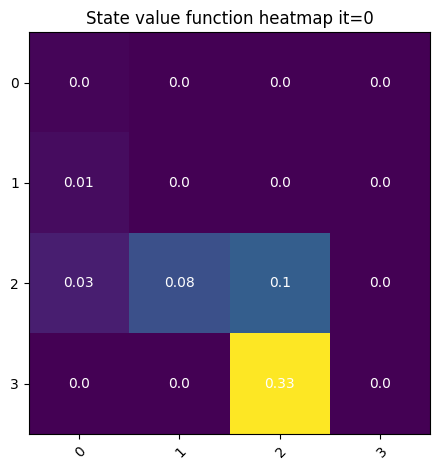

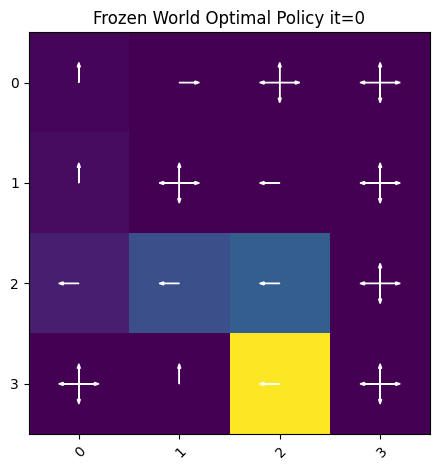

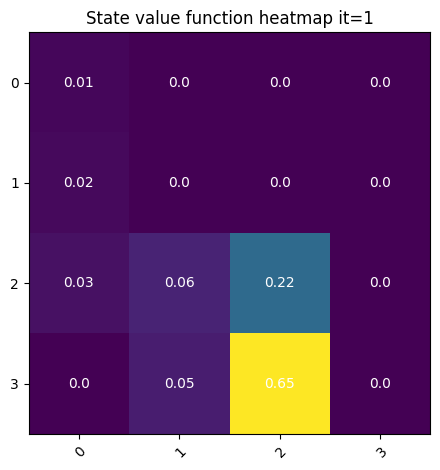

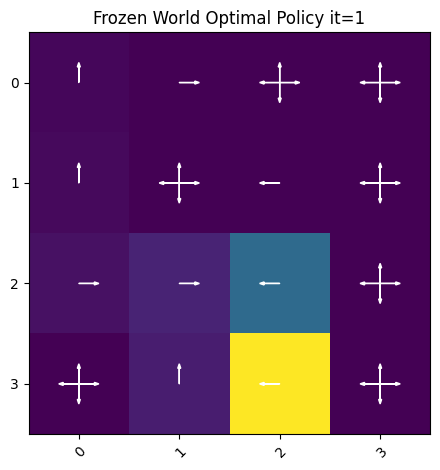

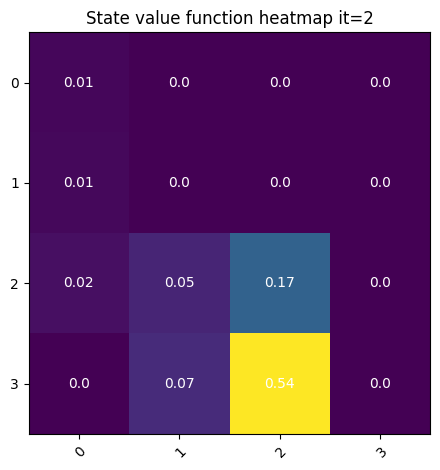

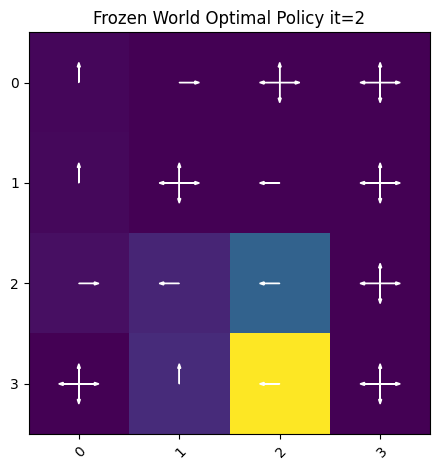

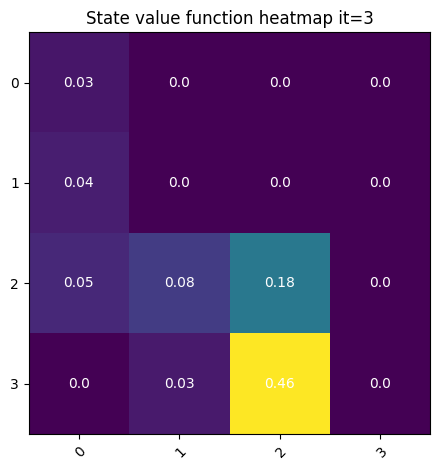

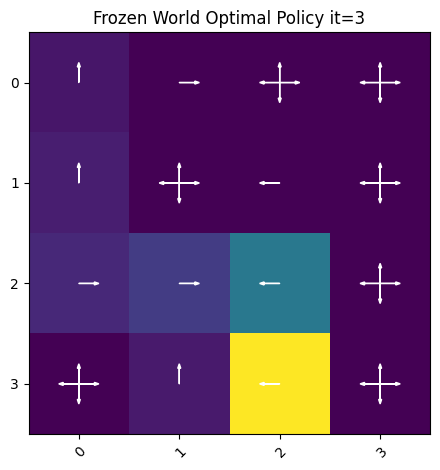

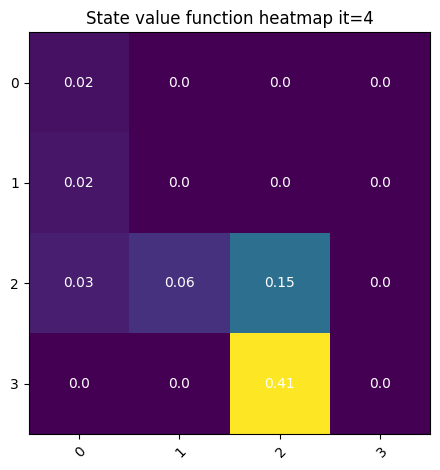

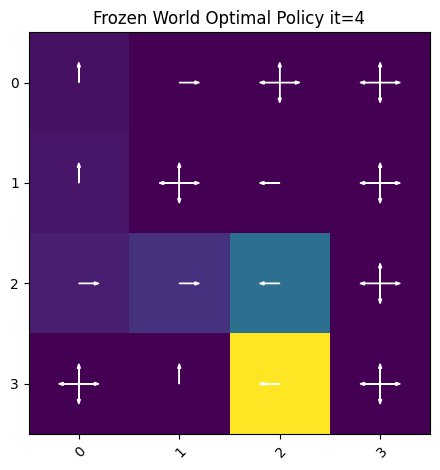

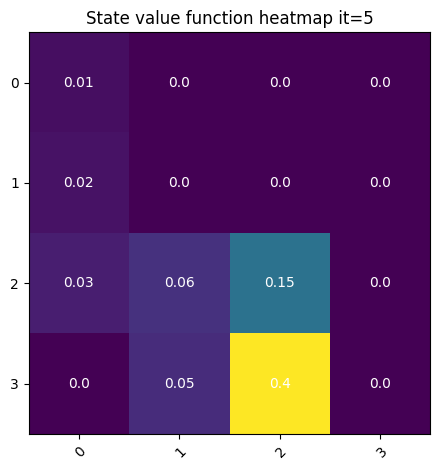

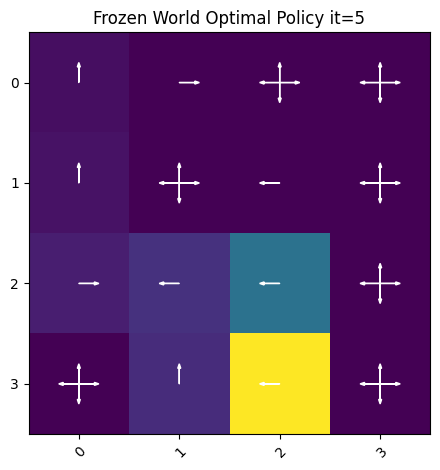

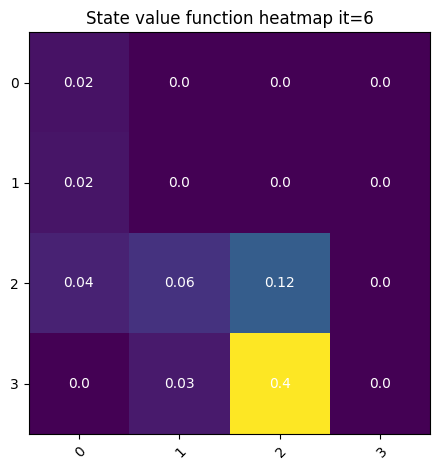

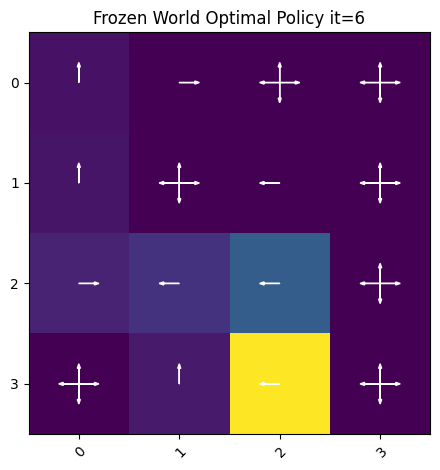

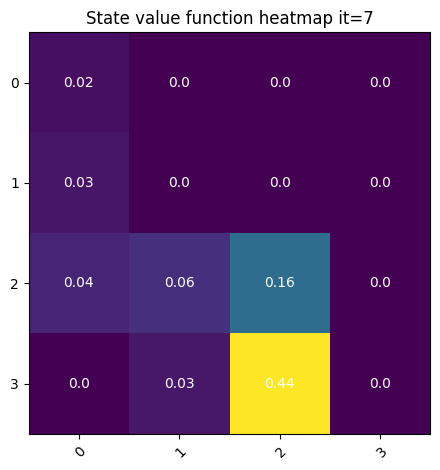

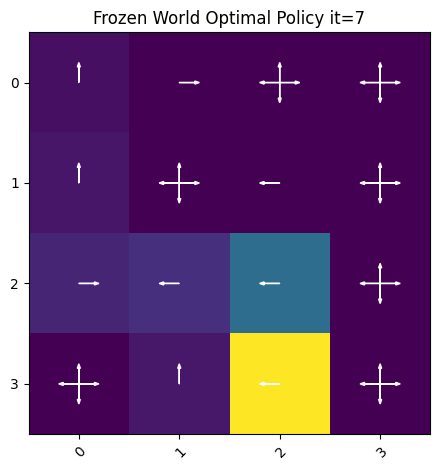

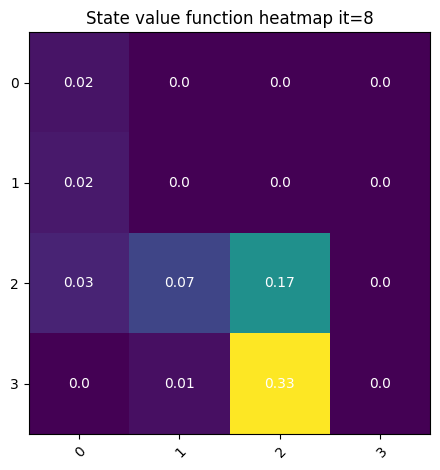

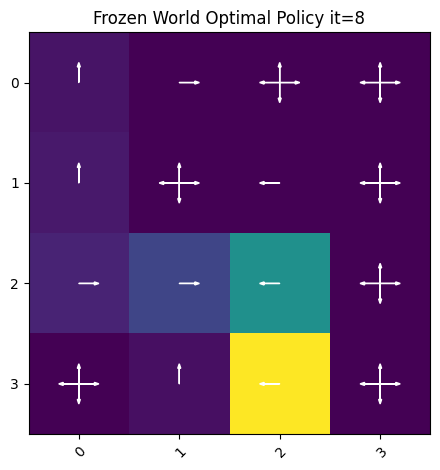

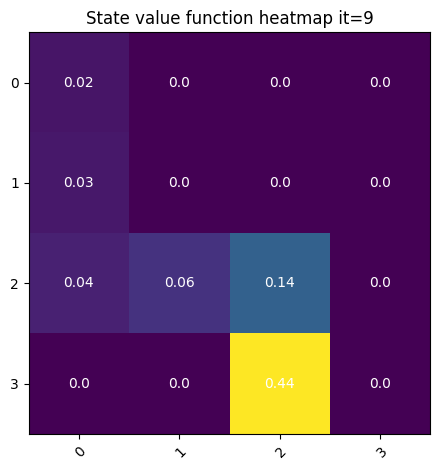

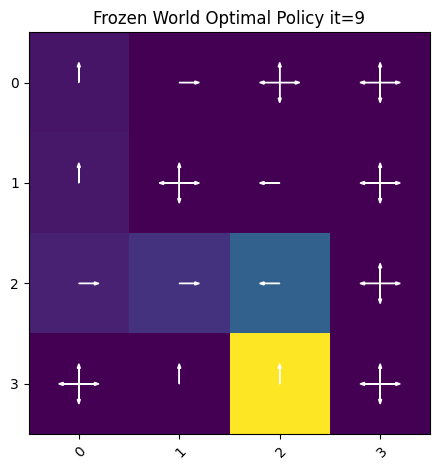

In [8]:
my_policy=Policy()
my_policy.optimise(env,10)